In [1]:
import sys
import os
import numpy as np
import MDAnalysis as mda
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
cur_path1 = os.getcwd()
print(cur_path1)

C:\Users\pcuser\Desktop\tutorial\AFP\tm\bias\6A\qbar6


In [3]:
q_star_arr = [ "bind", "1000" ]

In [5]:
#Get atom_pos for each universe for each time frame (N, timeframe, positions(M molecules,3))
atom_pos = []
u_list = []
index_file = "solid_like_atoms.index"


for i in q_star_arr:
    work_path = cur_path1 + "\\" +i
    os.chdir(work_path)
    u = mda.Universe("bias.gro","bias_whole.xtc")
    u_list += [u]
    
    solid_ndx = []
    df = open(index_file, "r+")
    for line in df.readlines():
        solid = np.fromstring(line, dtype=int, sep=' ') -1
        solid_ndx += [solid]
        
    print('there are %s time frames in %s q_star' %(len(solid_ndx), i))
    
    solid_pos = []
    for j in range(len(solid_ndx)):
        solid = solid_ndx[j]
        solid_poss = np.zeros([len(solid), 3])
        for k in range(len(solid)):
            solid_poss[k] = u.atoms[solid[k]].position
        solid_pos += [solid_poss]

    
    atom_pos += [solid_pos]
    
    

ref_pos = atom_pos[1]  #for 1500
atom_pos = atom_pos[:-1] #for bind

C:\Users\pcuser\anaconda3\lib\site-packages\MDAnalysis\topology\guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: M
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


there are 321 time frames in bind q_star
there are 251 time frames in 1000 q_star


In [7]:
#get surface atom's position
# surface_pos is the key

u = u_list[-1]
ref_indx = "surface.ndx"

sf = open(ref_indx, "r+")
surface_ndx = []
for line in sf.readlines():
    surface_ndx += [np.int(line)]
surface_ndx = np.array(surface_ndx)

#convert to python scheme
surface_ndx = surface_ndx - 1

surface_pos = []
for i in q_star_arr:
    work_path = cur_path1 + "\\" +i
    os.chdir(work_path)
    u = mda.Universe("bias.gro","bias_whole.xtc")
    
    surface_pos_i = np.zeros([len(surface_ndx), 3])
    for j in range(len(surface_ndx)):
        surface_pos_i[j] = u.atoms[surface_ndx[j]].position
    
    surface_pos += [surface_pos_i]

bind_surf_pos = surface_pos[0]
engulf_surf_pos = surface_pos[1]


# surface_pos = np.zeros([len(surface_ndx), 3])
# for i in range(len(surface_ndx)):
#     surface_pos[i] = u.atoms[surface_ndx[i]].position
# print('there are %s surface atoms in this simulation.' % surface_pos.shape[0])

In [26]:
# This code is written by Jeongmoon Choi
# email: jeongmoon2006@gmail.com

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

class density_near_surface:
    '''
    Calculates density near surface and returns heavy atoms that satisfies density > cutoff
    
    Args:
    atom_pos(list): atom position of interest per simulation, time (# of simulation, # time frame, (# of atom, 3))
    ref_pos(list): reference atom position of interest for one simulation. (# time frame, (# of atom, 3))
    surface_pos1(numpy.ndarray): surface atom position (# of surface atoms, 3) for IBS
    surface_pos2(numpy.ndarray): surface atom position (# of surface atoms, 3) for reference
    box1(numpy.ndarray): simuation box size (3,) for IBS
    box2(numpy.ndarray): simuation box size (3,) for reference
    radius_cutoff(float): cutoff for union of sphere's radius
    density_cutoff(float): cutoff for density
    
    Density counts number of ice molecules surrounded by a sphere centering i'th heavy atom's position and radius as radius_cutoff  

    '''
    
    def __init__(self, atom_pos, ref_pos, surface_pos1, surface_pos2, box1, box2, surface_index, radius_cutoff, density_cutoff=0.5):
        self.atom_pos = atom_pos
        self.ref_pos = ref_pos
        self.surface_pos1 = surface_pos1
        self.surface_pos2 = surface_pos2
        self.box1 = box1
        self.box2 = box2
        self.radius_cutoff = radius_cutoff
        self.density_cutoff = density_cutoff
        self.surface_index = surface_index
        
        #for reference
        self.ref_solid_count = np.zeros((len(self.surface_pos1), len(self.ref_pos))) # (# of surface atom, # of data frame)
        self.avg_ref_solid_count = np.zeros(len(self.surface_pos1),)
        
        #for real
        self.solid_count = [] # (# of data frame, # of surface atoms, # of simulations)
        self.avg_solid_count = []  #( # of surface atoms, # of simulations)
        
        #if i th surface atom;s density is greater than cutoff, it is 1, if not 0
        self.true_density = [] #(# of simulations, # of surface atoms)
        # index of surface atom where density is greater than cutoff
        self.surface_density_ndx = [] #(# of simulations, # of surface atoms)
        
        
    def get_ref_density(self):
        # i for time frame
        for i in range(len(self.ref_pos)):
            ref_poss = self.ref_pos[i]
            dist = np.abs(ref_poss[:, np.newaxis, :] - self.surface_pos2)
            cond = 1*(dist > self.box2/2)
            dist = abs(cond*self.box2 - dist)
            dist = np.sum(dist*dist, axis = 2).T
            dist = np.sqrt(dist)
            
            self.ref_solid_count[:,i] = np.count_nonzero( dist < self.radius_cutoff , axis = 1)

        self.avg_ref_solid_count = np.average(self.ref_solid_count, axis = 1)
        
        return self.avg_ref_solid_count
    
    def get_density(self):
        # i for simulation
        for i in range(len(self.atom_pos)):
            t_atom_position = self.atom_pos[i]
            solid_countt = np.zeros((len(self.surface_pos1), len(t_atom_position)))
            print(len(t_atom_position))
            
            #j for time frame
            for j in range(len(t_atom_position)):
                atom_poss = t_atom_position[j]
                dist = np.abs(atom_poss[:, np.newaxis, :] - self.surface_pos1)
                cond = 1*(dist > self.box1/2)
                dist = abs(cond*self.box1 - dist)
                dist = np.sum(dist*dist, axis = 2).T
                dist = np.sqrt(dist)
                
                solid_countt[:,j] = np.count_nonzero( dist < self.radius_cutoff, axis = 1)
            self.avg_solid_count += [np.average(solid_countt, axis = 1)]
        
        
        return self.avg_solid_count
    
    def compare_density(self):
        # i for simulation
        for i in range(len(self.atom_pos)):
            density = self.avg_solid_count[i]/self.avg_ref_solid_count
            true_density1 = density > self.density_cutoff
            true_density2 = self.avg_ref_solid_count > np.average(self.avg_ref_solid_count)/3
            true_density = true_density1*true_density2
            true_density = true_density.astype(int)
            surface_index = true_density*self.surface_index
            surface_index = surface_index[np.nonzero(surface_index)]
            
            self.true_density += [true_density]
            self.surface_density_ndx += [surface_index]
        
        return self.true_density, self.surface_density_ndx

In [27]:
dnf = density_near_surface(atom_pos, ref_pos, bind_surf_pos, engulf_surf_pos, np.array([88.5889, 58.8286, 63.2556]), np.array([65.2592, 80.3189, 60.2392]), surface_ndx, 6, 0.5)

In [28]:
avg_ref_solid_count = dnf.get_ref_density()

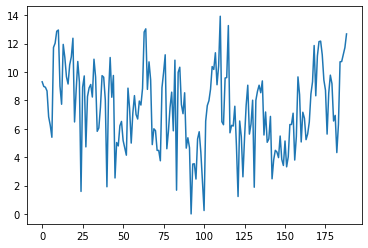

In [29]:
plt.plot(avg_ref_solid_count)

321


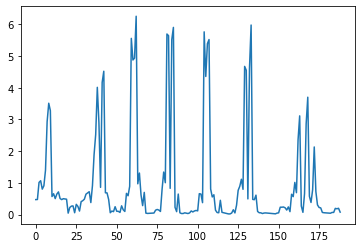

In [30]:
avg_solid_count = dnf.get_density()
plt.plot(avg_solid_count[0])

1


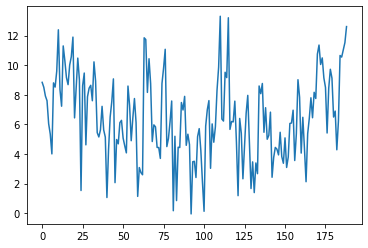

In [32]:
print(len(avg_solid_count))
plt.plot(avg_ref_solid_count - avg_solid_count[0])

In [33]:
true_density, true_surface_index = dnf.compare_density()

<ipython-input-26-95064cf5662d>:92: RuntimeWarning: divide by zero encountered in true_divide
  density = self.avg_solid_count[i]/self.avg_ref_solid_count


In [34]:
true_surface_index

[array([287, 291, 311, 315, 456, 460, 480, 484, 603, 627, 769, 773, 793,
        797, 933])]

In [22]:
true_surface_index

[array([437, 632])]

In [ ]:
os.chdir(cur_path1)
np.savetxt('IBS_density_0.5.txt',true_surface_index[0], fmt='%s')